<a href="https://colab.research.google.com/github/cclmcesarschool/RNA-e-Deep-Learning---CESAR-School-2023.2/blob/main/Atividade4.2/Atividade_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

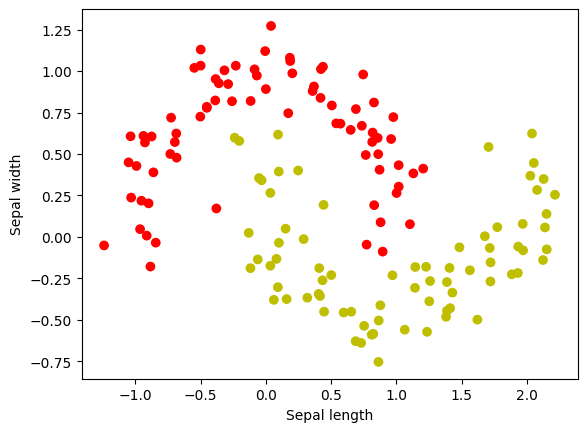

In [ ]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

In [ ]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),

        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
  )
)


In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

In [ ]:
predict(model, X_tensor)

array([14,  2, 14, 14, 14,  2,  2,  2, 14, 14,  2,  2,  2, 14, 14,  2, 14,
       14, 14,  2,  2,  2,  2, 14, 14, 14, 14,  2, 14, 14,  5, 14, 14,  2,
       14, 14, 14,  2, 14, 14, 14,  2,  2, 14,  2, 14, 14,  2,  2,  2,  2,
       14,  2, 14, 14, 14,  2, 14, 14,  2, 14,  2,  2, 14, 14, 14, 14,  2,
       14, 14, 14,  2, 14, 14, 14,  2,  2,  2, 14, 14,  2,  2, 14, 14, 14,
        2, 14, 14, 14, 14, 14, 14,  2, 14,  2, 14,  2, 14, 14, 14,  2,  2,
        2, 14, 14, 14, 14, 14, 14, 14,  2, 14, 14, 14, 14, 14, 14,  2,  2,
        2, 14, 14, 14, 14, 14, 14, 14, 14,  2, 14,  2, 14, 14, 14, 14, 14,
       14,  2,  2, 14, 14, 14, 14, 14, 14, 14, 14, 14,  2, 14])

In [ ]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

Final loss: tensor(0.0102)


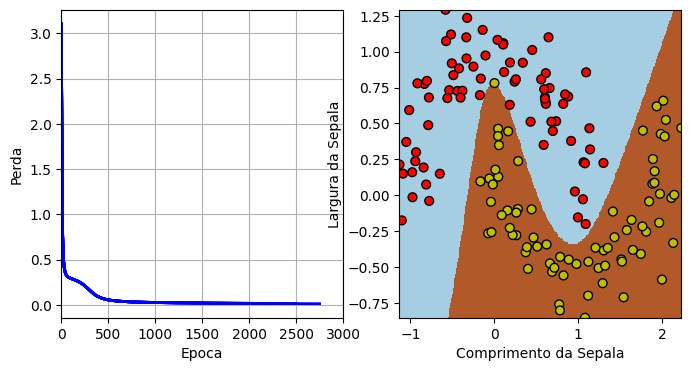

In [ ]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

In [ ]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([20, 2])
tensor([[-0.5160, -0.0627],
        [-0.7138,  0.5621],
        [ 0.5906,  0.3514],
        [-0.8826,  0.3620],
        [ 0.1700,  0.5984],
        [-1.4791, -0.2052],
        [-2.7028, -0.7663],
        [ 1.9148,  0.0164],
        [ 3.2358,  0.3862],
        [ 0.5758,  0.2532],
        [ 0.5231, -0.3285],
        [-0.4874,  0.2284],
        [-0.3873, -0.8587],
        [ 0.7885,  0.1704],
        [-0.7071, -0.0329],
        [-1.2374, -0.3990],
        [ 0.4294, -0.4407],
        [-1.0722,  0.4208],
        [ 0.4277, -0.9165],
        [-0.6275,  0.5074]])
dense.0.bias    torch.Size([20])
tensor([ 0.2342,  0.8701,  0.2630,  1.1708,  0.5816, -0.4552,  1.6029,  0.5599,
        -1.2029, -0.6554, -0.5206, -0.2368, -0.1937, -0.0782, -0.3148,  0.5826,
        -0.4315, -0.8605, -0.7777,  0.7335])
dense.2.weight  torch.Size([20, 20])
tensor([[ 1.7582e-01, -3.3161e-02,  2.8249e-02, -2.0038e-02, -1.5299e-02,
          9.5896e-02,  1.5399e-01,  8.1570e-02, -3.235

In [ ]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


In [ ]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.

Ao incluir muitos neuronios e muitas camadas as funções de ativação Relu e Sigmoid entre camadas de função linear a resolução se torna mais rápida.

Ao incluir a função tangente com 20 neuronios e 3 camadas, a equação consegue realizar o objetivo atingindo 1 de acuracia.

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.

Caso seja substituido a ReLU pela Sigmoid a equação não é capaz de romper a não linearidade.



3. O que ocorre quando não se utiliza ativação não linear entre camadas?

Sem utilizar as funções de ativação, a função não será capaz de apresentar uma solução não-linear, não resolvendo o problema. Sem as funções de ativação não consegue quebrar a linearidade, permanecendo uma reta.
